In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

def get_model_output(model, layers):
    outputs = [model.get_layer(layer).output for layer in layers]
    return Model([model.input], outputs)

In [3]:
def load_and_process_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((224, 224, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

In [4]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

content_model = get_model_output(vgg, content_layers)
style_model = get_model_output(vgg, style_layers)

In [5]:
def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    a = tf.reshape(tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def style_loss(style, generated):
    S = gram_matrix(style)
    G = gram_matrix(generated)
    return tf.reduce_mean(tf.square(S - G))

content_weight = 1e3
style_weight = 1e-2

def compute_loss(content_image, style_image, generated_image):
    content_output = content_model(content_image)
    generated_content_output = content_model(generated_image)
    content_loss_val = content_loss(content_output, generated_content_output)
    
    style_outputs = style_model(style_image)
    generated_style_outputs = style_model(generated_image)
    style_loss_val = sum([style_loss(style, gen) for style, gen in zip(style_outputs, generated_style_outputs)])
    
    total_loss = content_weight * content_loss_val + style_weight * style_loss_val
    return total_loss

In [6]:
generated_image = tf.Variable(load_and_process_image("line_obama.png"), dtype=tf.float32)

optimizer = tf.optimizers.Adam(learning_rate=5.0)

In [7]:
@tf.function()
def train_step(content_image, style_image, generated_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(content_image, style_image, generated_image)
    gradient = tape.gradient(loss, generated_image)
    optimizer.apply_gradients([(gradient, generated_image)])
    return loss

Epoch 0: Loss: 7208491008.0


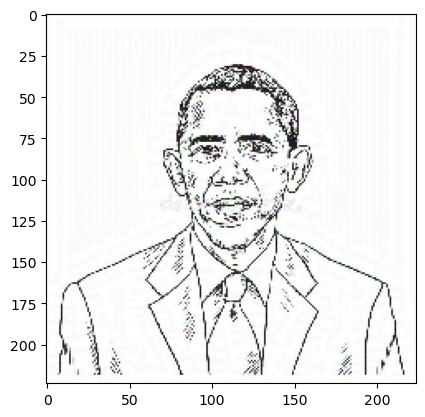

Epoch 500: Loss: 17965150.0


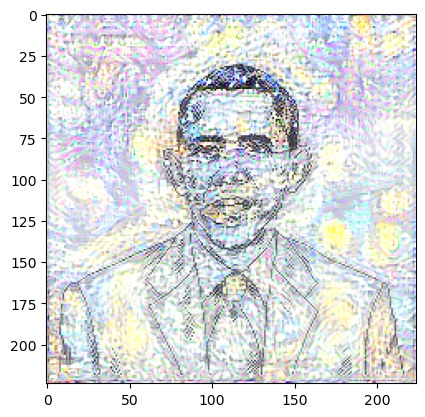

Epoch 1000: Loss: 12946294.0


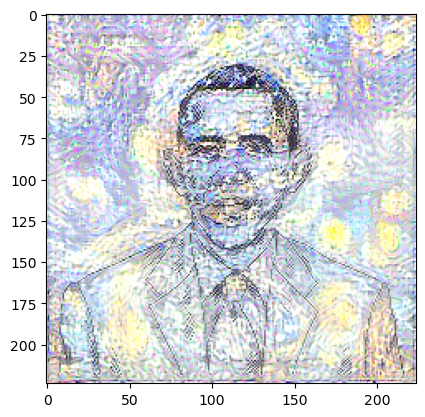

Epoch 1500: Loss: 10152379.0


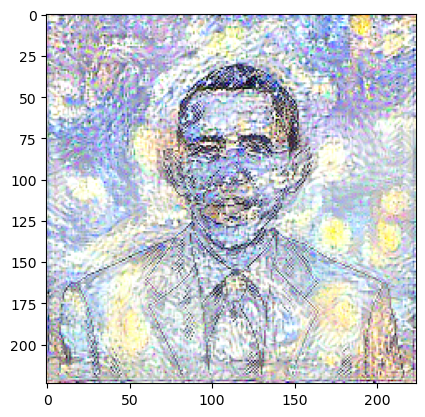

Epoch 2000: Loss: 8780851.0


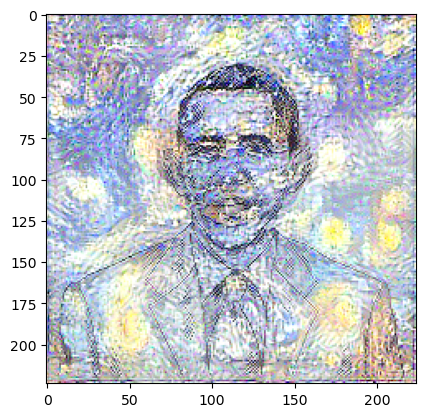

Epoch 2500: Loss: 7838389.0


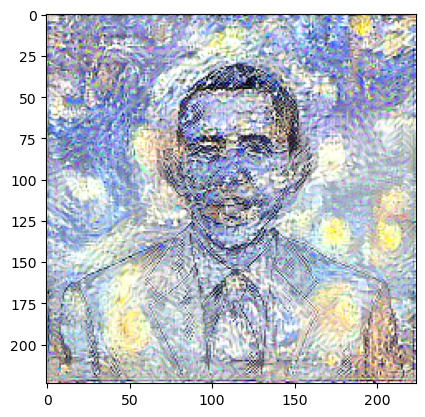

Epoch 3000: Loss: 7315386.5


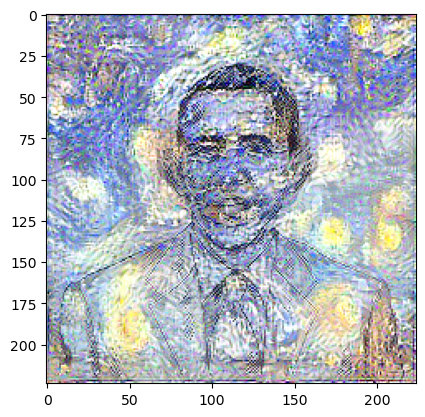

Epoch 3500: Loss: 6518986.0


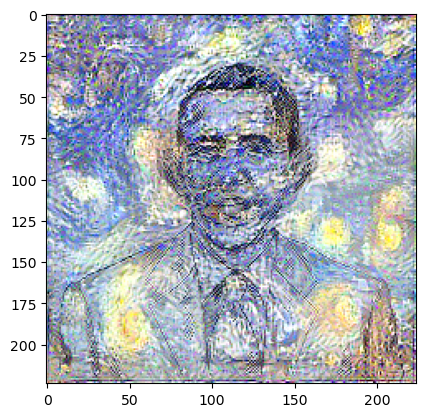

Epoch 4000: Loss: 6962709.5


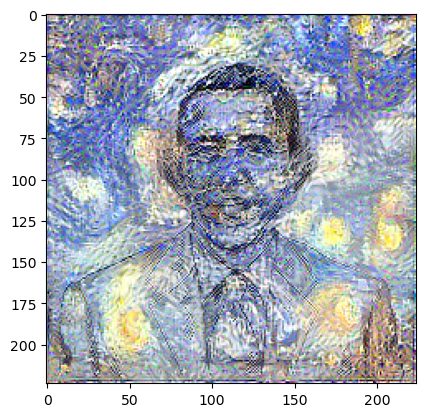

Epoch 4500: Loss: 6266276.5


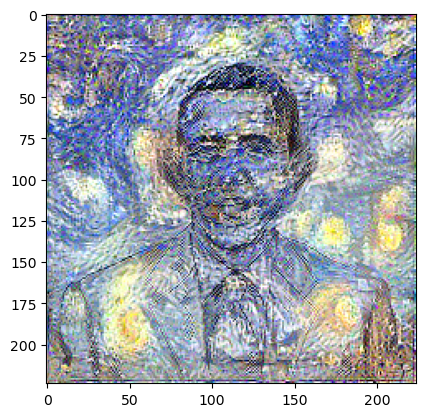

Epoch 5000: Loss: 5681377.0


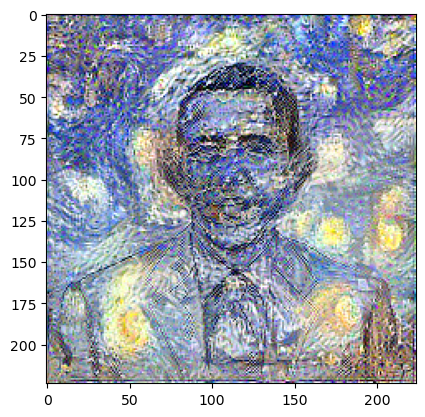

Epoch 5500: Loss: 6483172.5


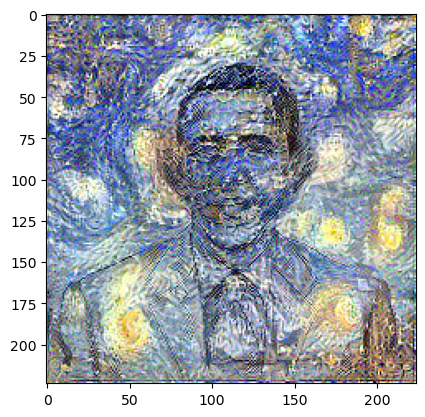

Epoch 6000: Loss: 5308339.0


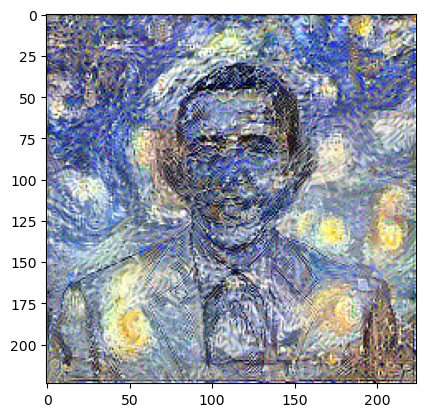

Epoch 6500: Loss: 16013264.0


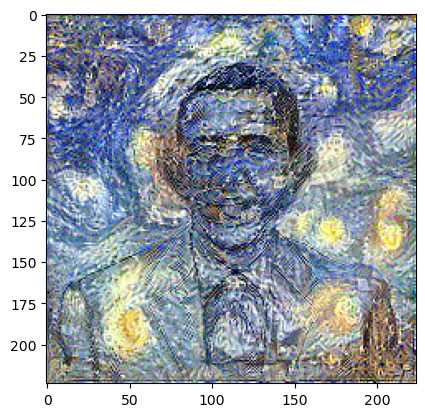

Epoch 7000: Loss: 5084235.0


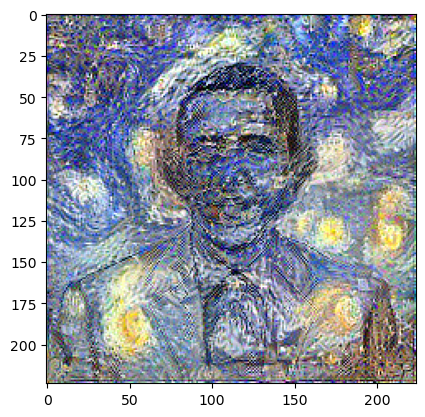

Epoch 7500: Loss: 4891103.5


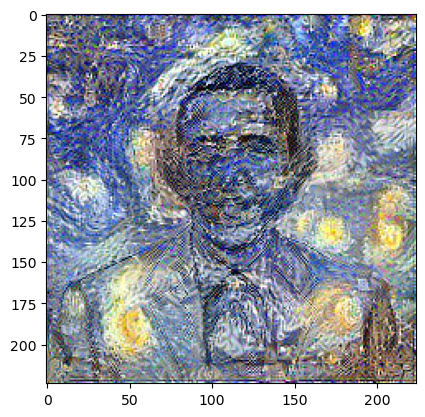

Epoch 8000: Loss: 5072550.0


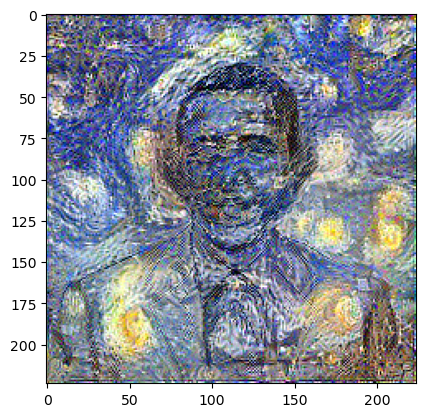

Epoch 8500: Loss: 6531744.0


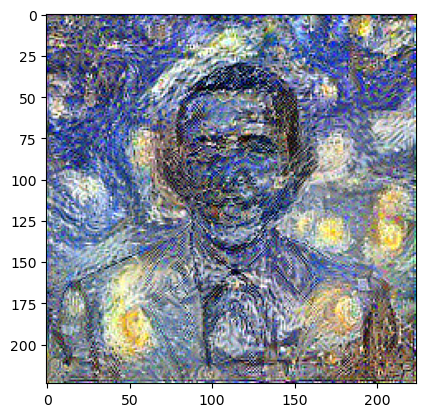

Epoch 9000: Loss: 4718743.5


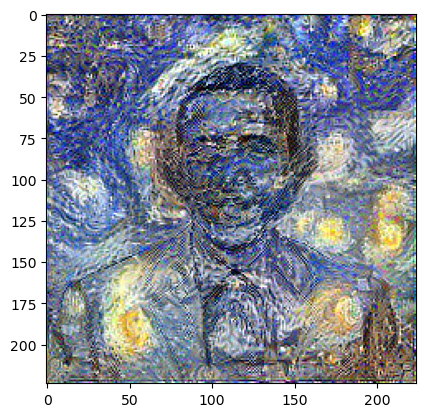

Epoch 9500: Loss: 4801665.0


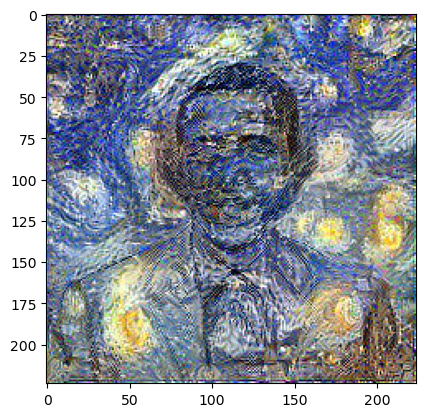

In [8]:
epochs = 10000
patience = 3000
best_loss = float('inf')
wait = 0
losses = []

content_image = load_and_process_image("line_obama.png")
style_image = load_and_process_image("Starry-Night.png")

for epoch in range(epochs):
    loss = train_step(content_image, style_image, generated_image)
    loss_value = loss.numpy()
    losses.append(loss_value)
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss: {loss_value}")
        plt.imshow(deprocess_image(generated_image.numpy()))
        plt.show()
        
    if loss_value < best_loss:
        best_loss = loss_value
        wait = 0
        # Save the best model
        generated_image_np = generated_image.numpy()
        np.save("best_generated_image.npy", generated_image_np)
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch} with best loss {best_loss}")
            break

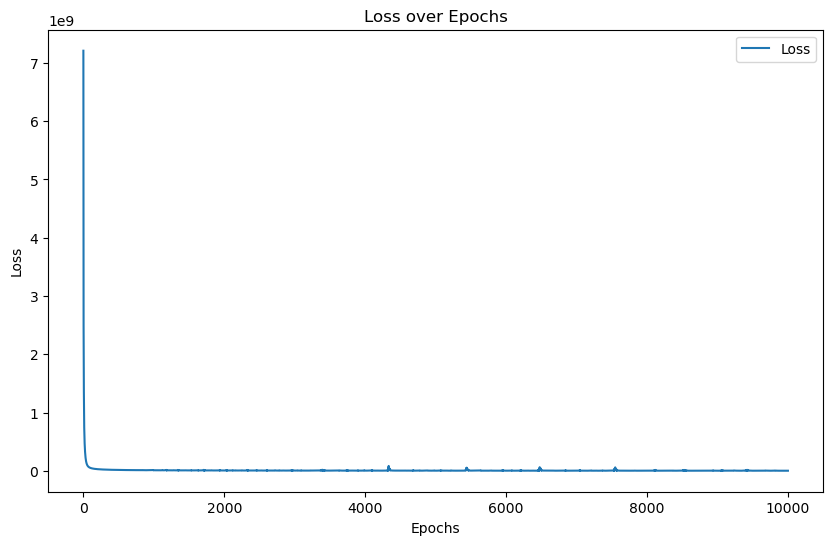

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()